### 載入所需的Libraries

In [25]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import List

### 載入資料

In [26]:
# read data from spam.csv

sms_data = pd.read_csv('spam.csv',encoding='latin-1',usecols=[0,1])
sms_data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [27]:
sms_data.groupby('v1').count()

,v2
v1,
ham,4825
spam,747


In [28]:
sms_data['v1'] = sms_data['v1'].map({'ham':0,'spam':1})
sms_data.columns = ['label','content']
sms_data

,label,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


### 切分資料
將資料依據label比例切分為training data與testing data

In [67]:
###<your code>###
sms_train,sms_test = train_test_split(sms_data,test_size=0.2, random_state=0, shuffle=True, stratify=sms_data.label)

sms_train = sms_train.reset_index(drop=True)
sms_test = sms_test.reset_index(drop=True)
print(sms_train.groupby("label").count())
print(sms_test.groupby("label").count())

       content
label         
0         3859
1          598
       content
label         
0          966
1          149


### 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [68]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    for i in range(len(df)):
        # make all content to lowercase
        ###<your code>###
        df['content'][i] = df['content'][i].lower()

        # remove all punctuations
        ###<your code>###
        pattern = r'[a-zA-Z]+'
        df['content'][i] = ' '.join(re.findall(pattern, df['content'][i]))
    
    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Train:
   label                                            content
0      0          am also doing in cbe only but have to pay
1      0    ok i thk i got it then u wan me come now or wat
2      1  rt king pro video club need help info ringtone...
3      0           and popping lt gt ibuprofens was no help
4      0                            am in gobi arts college
Test:
   label                                            content
0      0                                       anything lar
1      0  great never been better each day gives even mo...
2      0  haha they cant what at the most tmr forfeit ha...
3      0                       i am late i will be there at
4      0  wen ur lovable bcums angry wid u dnt take it s...


In [69]:
# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
len(set(" ".join(list(x_train + x_test)).split()))

7708

### TF-IDF
可以發現種共有7708個字詞，這裡使用TF-IDF將來選取最高分的前2000個字詞
(若忘記的學員可參考先前TF-IDF課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [70]:
###<your code>###
vectorizer = TfidfVectorizer(max_features=2000) # 取前兩千名
vectorizer.fit(x_train)
tfidf_train = vectorizer.transform(x_train)
tfidf_test = vectorizer.transform(x_test)


print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
(tfidf_train, tfidf_test)

Number of unique word: 2000


(<4457x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 51227 stored elements in Compressed Sparse Row format>,
 <1115x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 12236 stored elements in Compressed Sparse Row format>)

In [76]:
x_train[0].split()

['am', 'also', 'doing', 'in', 'cbe', 'only', 'but', 'have', 'to', 'pay']

### 建立共現矩陣

In [74]:
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    # initialize co-occurrence matrix
    co_matrix = np.zeros(shape=(len(vocab_list), len(vocab_list)), dtype=np.int32)
    
    for idx, sms in enumerate(corpus):
        sms = sms.split()
        sms_ids = [word2idx[word] for word in sms if word in vocab_list] # tokenize
        
        for center_i, center_word_id in enumerate(sms_ids):
            context_ids = sms_ids[max(0, center_i - window_size):center_word_id]
            context_len = len(context_ids)
            
            for left_i, left_word_id in enumerate(context_ids):
                
                if use_weighting:
                    distance = context_len - left_i
                    increment = 1./float(distance)
                
                else:
                    increment = 1
                    
                co_matrix[center_word_id, left_word_id] += increment
                co_matrix[left_word_id, center_word_id] += increment

        if verbose:
            if idx != 0 and idx % 500 == 0:
                print(f"finishing {idx+1}/{len(corpus)}")
    
    print("Done")
    
    if use_weighting:
        # if use weighting, then we set the co-occurrence with the word itself to 1.0
        np.fill_diagonal(co_matrix, 1.)
        
    return co_matrix


co_matrix = create_co_matrix(
                x_train, 
                vectorizer.get_feature_names(),
                vectorizer.vocabulary_,
                window_size=3, 
                use_weighting=True, 
                verbose=True
            )

co_matrix

finishing 501/4457
finishing 1001/4457
finishing 1501/4457
finishing 2001/4457
finishing 2501/4457
finishing 3001/4457
finishing 3501/4457
finishing 4001/4457
Done


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

### 建立PPMI矩陣

In [77]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    M = np.zeros_like(co_matrix, dtype=np.float32)
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    total = co_matrix.shape[0]*co_matrix.shape[1]
    
    count = 0
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j] + eps))
            M[i, j] = max(0, pmi)
            
            if verbose:
                count += 1
                if count % 10 == 0 or count == total:
                    print(f"{count}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]


array([[16.664892 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  8.021035 ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  2.0391257, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ..., 11.4949665,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  6.489966 ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
        11.050181 ]], dtype=float32)

### 使用SVD降維
利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用SVD對PPMI進行降維)

Number of components = 10 and explained variance = 0.5905911624619429
Number of components = 20 and explained variance = 0.6717842118004841
Number of components = 30 and explained variance = 0.7211471620521661
Number of components = 40 and explained variance = 0.7555484923326585
Number of components = 50 and explained variance = 0.781934063083024
Number of components = 60 and explained variance = 0.8033733886141462
Number of components = 70 and explained variance = 0.821913199935785
Number of components = 80 and explained variance = 0.8377805039648735
Number of components = 90 and explained variance = 0.8514708730960844
Number of components = 100 and explained variance = 0.8631752398765647
Number of components = 110 and explained variance = 0.8734847058920858
Number of components = 120 and explained variance = 0.8825360790819764
Number of components = 130 and explained variance = 0.8906746489380651
Number of components = 140 and explained variance = 0.8981779408910089


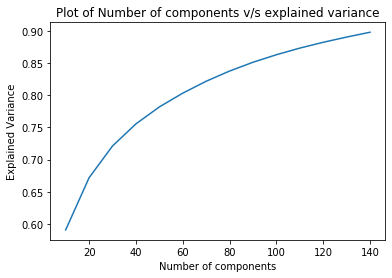

In [79]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,150,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim)
    svd.fit(co_matrix)
    explained_variance = svd.explained_variance_ratio_.sum()
    variance_sum.append(explained_variance) #explained
    print("Number of components = %r and explained variance = %r"%(dim, explained_variance))

    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [80]:
# choose 140 as final dimension to reduce to 
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
###<your code>###

svd = TruncatedSVD(n_components=140)
svd.fit(co_matrix)
re_co_matrix = svd.transform(co_matrix)

In [92]:
re_co_matrix.shape

(2000, 140)

In [112]:
np.array([re_co_matrix[0],re_co_matrix[1]]).mean(axis=0)

array([ 1.29361815e+00, -7.69121363e-01, -3.15924184e-01,  2.70056687e-01,
       -3.74043941e-01, -1.39924757e-01,  1.03567686e-01,  1.46362871e-01,
       -1.06793090e-01, -1.43511706e-01, -1.93577596e-01,  1.06235831e-01,
       -3.09569925e-01, -2.43717294e-01,  2.16151725e-01, -1.32476048e-01,
       -5.27287920e-01,  2.55263558e-01,  4.12992143e-02, -2.87010475e-01,
       -8.77841589e-02,  5.09397939e-02, -2.82065257e-01,  7.94982852e-02,
       -4.56889732e-02, -4.04390634e-02, -1.21065949e-02,  2.73099190e-02,
        3.01498200e-01, -1.81898992e-01, -1.49064930e-01,  2.13692730e-01,
        9.56167174e-02, -1.49667419e-01, -1.73670192e-02,  7.89955408e-02,
       -2.39441441e-01,  1.12574739e-01,  2.21564860e-01, -1.71471237e-01,
        3.89155332e-01,  1.35050710e-01,  9.65740990e-02,  1.61277730e-01,
       -4.38676229e-02, -2.41659808e-01,  1.39799422e-03, -1.15079335e-01,
       -1.26060795e-01, -1.07136059e-01,  5.02573387e-02,  1.24530131e-01,
       -1.22644206e-01, -

### 使用KNN模型進行分類
在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [81]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vecto
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([re_co_matrix[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("="*50)
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

document 333 doesn't contain word in vocab_list
erutupalam thandiyachu


document 377 doesn't contain word in vocab_list
audrie lousy autocorrect


document 847 doesn't contain word in vocab_list
received understood n acted upon


document 852 doesn't contain word in vocab_list
tf p


document 899 doesn't contain word in vocab_list



document 1208 doesn't contain word in vocab_list
v ma fan


document 1419 doesn't contain word in vocab_list
g w r


document 1710 doesn't contain word in vocab_list
hanks lotsly


document 1830 doesn't contain word in vocab_list
k k congratulation


document 1889 doesn't contain word in vocab_list
garbage bags eggs jam bread hannaford wheat chex


document 1996 doesn't contain word in vocab_list
u


document 3526 doesn't contain word in vocab_list
raviyog peripherals bhayandar east


document 3900 doesn't contain word in vocab_list
beerage


document 3985 doesn't contain word in vocab_list
ultimately tor motive tui achieve korli


document 232 doesn't co

In [115]:
missing_train_list

[333, 377, 847, 852, 899, 1208, 1419, 1710, 1830, 1889, 1996, 3526, 3900, 3985]

In [82]:
from sklearn.neighbors import KNeighborsClassifier

# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(doc_vec_train, y_train_filter)
train_pred = knn.predict(doc_vec_train)

# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
test_pred = knn.predict(doc_vec_test)

In [83]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"train acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.9761422462300248
train acc: 0.9694244604316546
